In [1]:
import numpy as np
from sys import path

path.append('src/')
from samplers import WienerRainbowPutOptionSampler, GeometricBrownianMotionPutSampler
from american_monte_carlo import PricerAmericanMonteCarlo
from basis_functions import PolynomialTransformer
import matplotlib.pyplot as plt
from BinomialTree import price_gbm_put


In [2]:
%load_ext autoreload
%autoreload 2

# Rainbow Wiener 2-dimensional

In [3]:
sampler = WienerRainbowPutOptionSampler(
    cnt_trajectories=1_000_000,
    cnt_times=3,
    t=1,
    time_grid = None,
    seed = 345,
    sigmas = [1., 1.],
    strike=0.
)

sampler.sample()

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

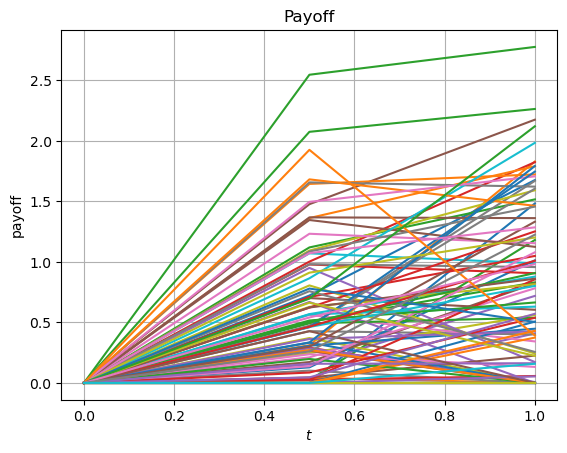

In [4]:
sampler.plot(100)

In [7]:
in_the_money_indices = np.where(sampler.payoff[:, 1] > 1e-9)[0]
len(in_the_money_indices)

749942

In [8]:
features = sampler.markov_state[in_the_money_indices, 1]
transformed = PolynomialTransformer(5).fit_transform(features)
transformed.shape

(749942, 21)

In [9]:
regularization = np.eye(transformed.shape[1], dtype=float) * 0.
inv = np.linalg.pinv((transformed.T @ transformed + regularization), rcond=1e-4)
weights = inv @ transformed.T @ sampler.payoff[in_the_money_indices, 2]
continuation_value = transformed @ weights

In [10]:
indicator = (continuation_value < sampler.payoff[in_the_money_indices, 1])
indicator.sum()

1109

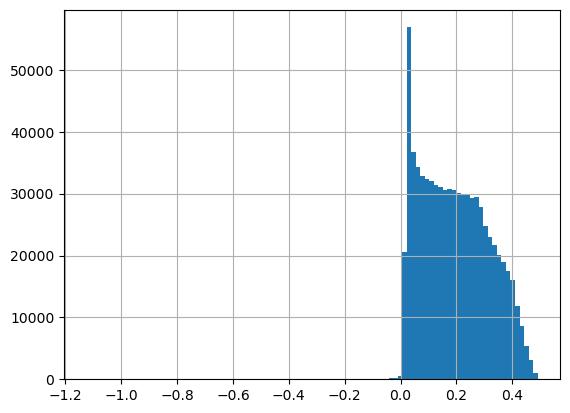

In [11]:
plt.hist(continuation_value - sampler.payoff[in_the_money_indices, 1], bins=100);
plt.grid()

# Тесты AMC (Одномерный) vs Tree

In [1]:
import numpy as np
from sys import path

path.append('src/')
from samplers import WienerRainbowPutOptionSampler, GeometricBrownianMotionPutSampler
from american_monte_carlo import PricerAmericanMonteCarlo
from basis_functions import PolynomialTransformer
import matplotlib.pyplot as plt
from BinomialTree import price_gbm_put


In [2]:
from american_monte_carlo import _plot_progress

In [2]:
option_params = {
    "asset0": 100.,
    "sigma": 0.1,
    "r": 0.5,
    "strike": 100.,
    "t": 1
}

In [5]:
EPSILON = 1e-1
CNT_TIMES = 100

#### Варьируем `r (mu)`

`--` будет нижней оценкой, `-.` верхней

In [31]:
r_linspace = np.linspace(0, 1, num = 15)

 88%|########7 | 87/99 [00:00<00:00, 119.59it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


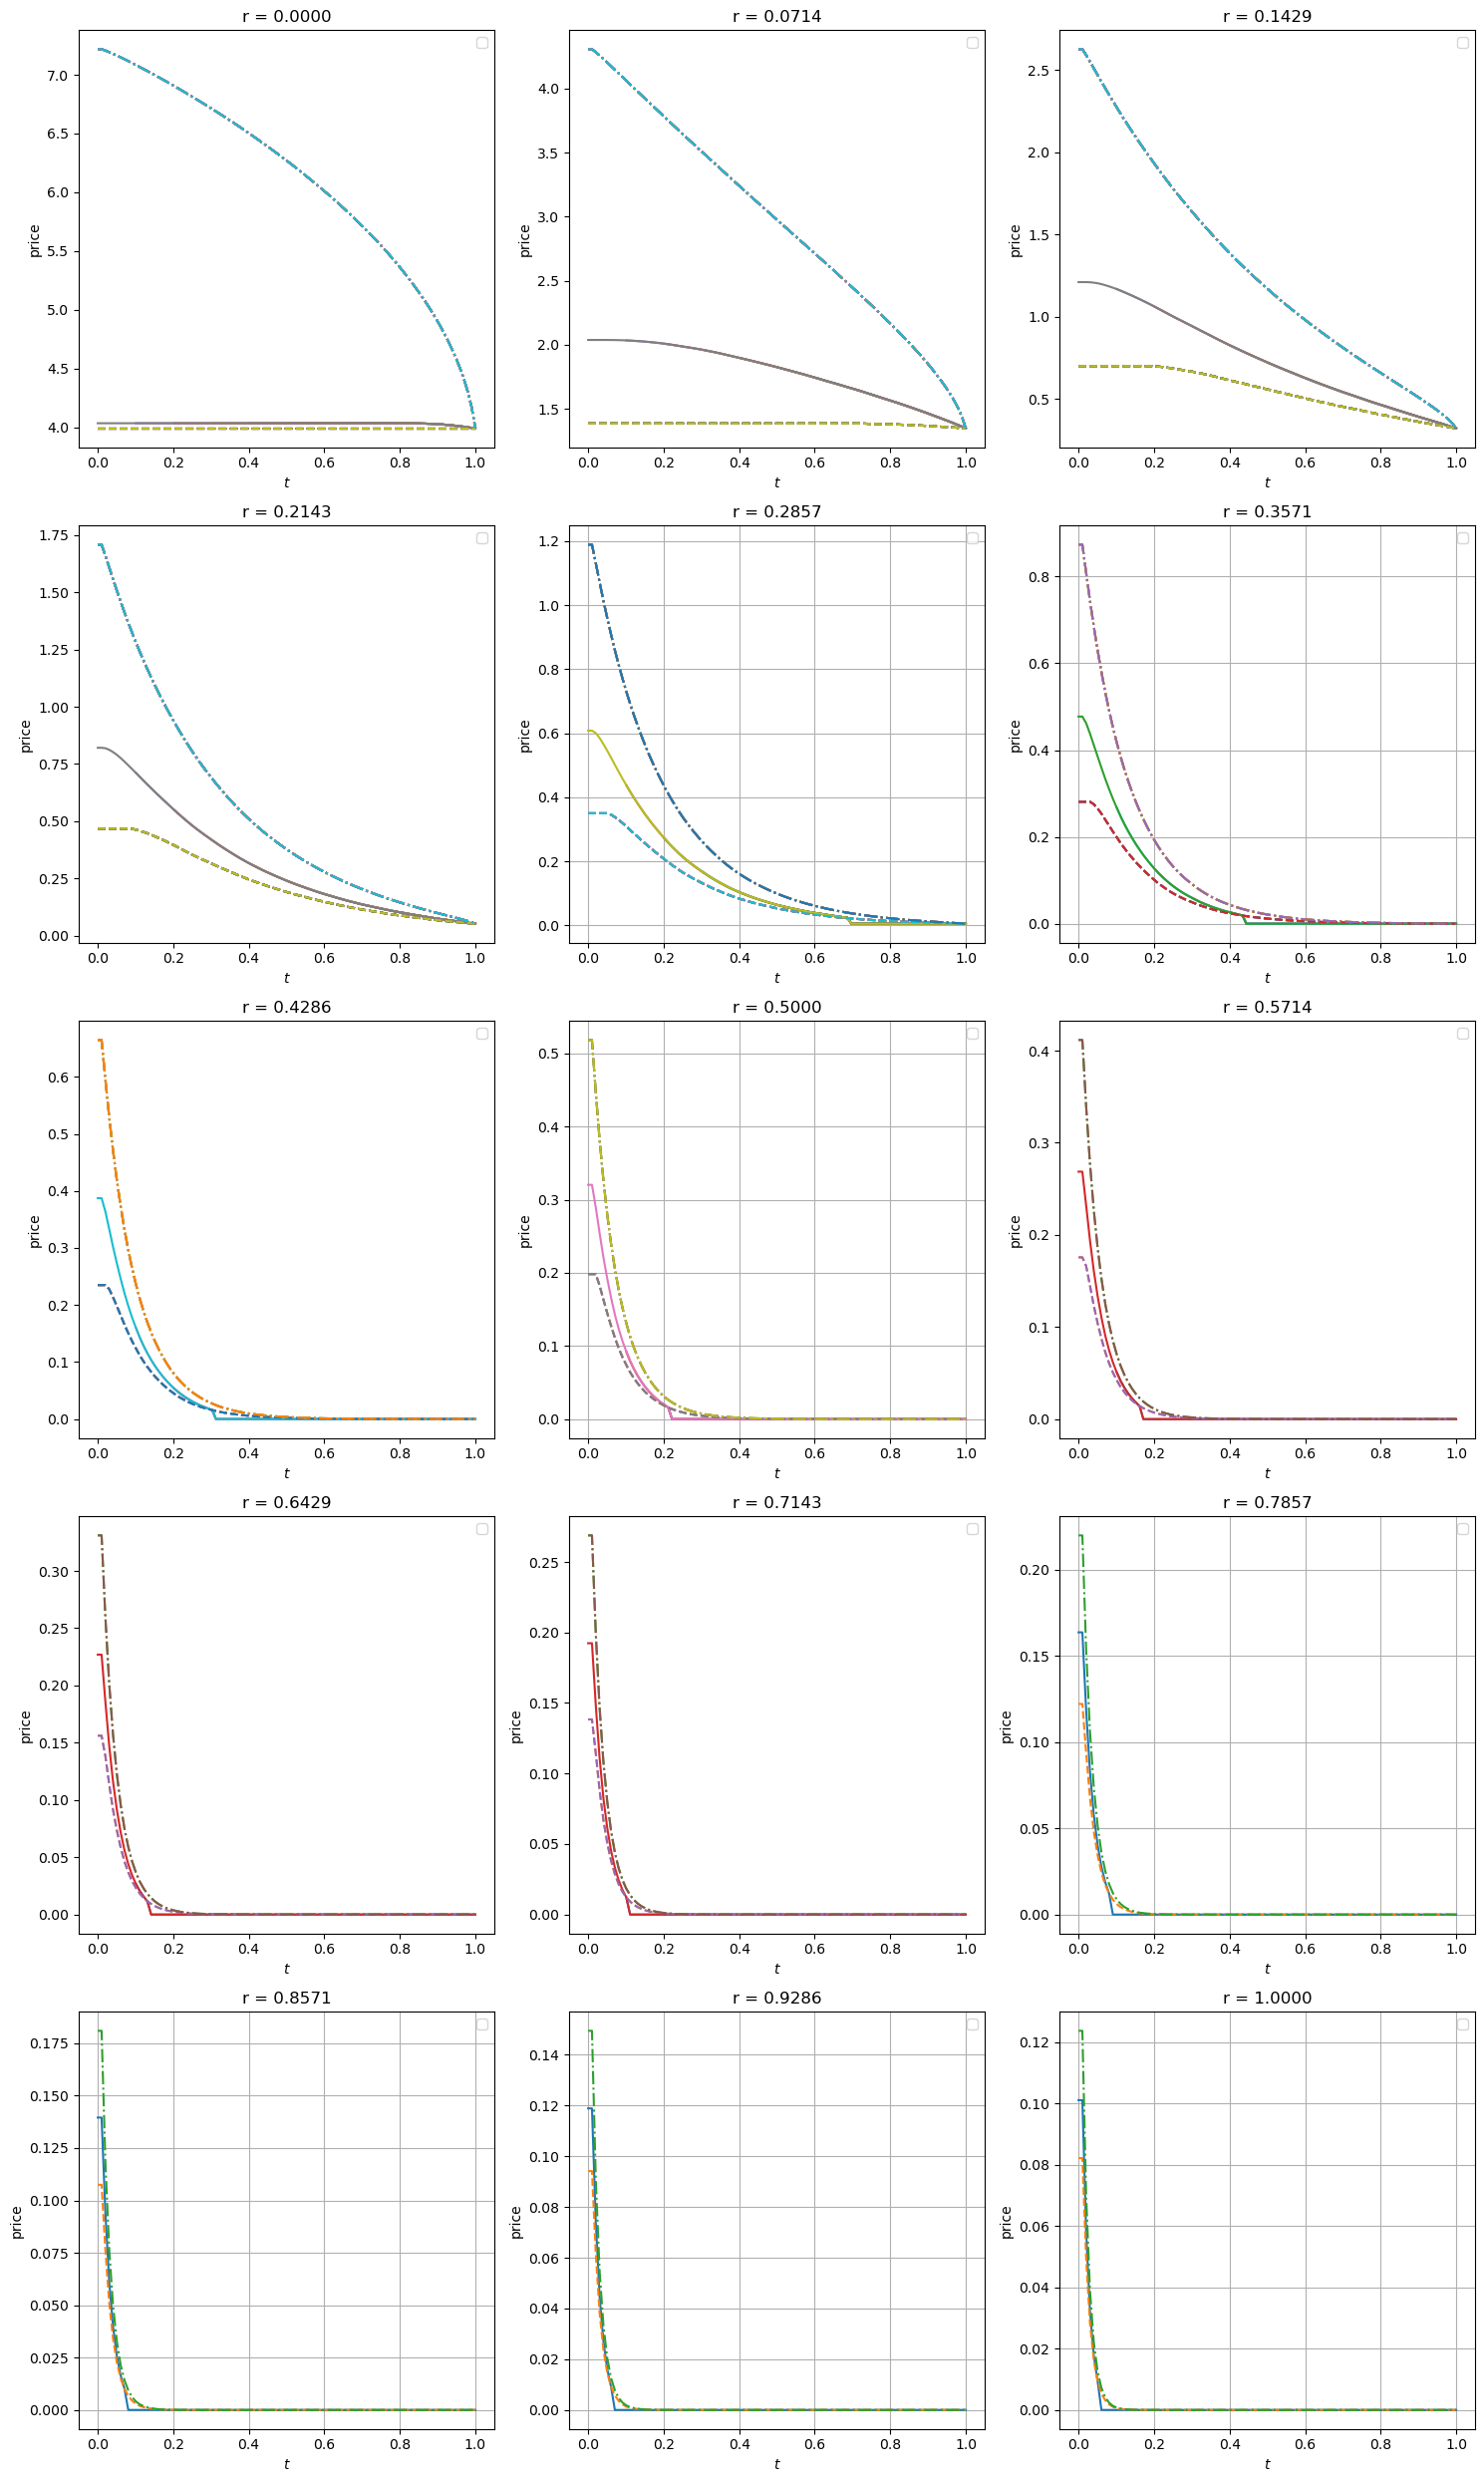

In [7]:
nums = len(r_linspace)

nrows = 5
ncols = 3  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))
axes = axes.flatten()

for idx, r_val in enumerate(r_linspace):
    option_params["r"] = r_val
    
    amc = PricerAmericanMonteCarlo(
        sampler=GeometricBrownianMotionPutSampler(
            cnt_trajectories=1_000_000,
            cnt_times=100,
            seed=345,
            **option_params
        ),
        regularization_alpha=1e-3
    )

    ax = axes[idx]
    amc.price(test=False, quiet=False, ax=ax)
    ax.set_title(f"r = {r_val:.4f}")

plt.tight_layout()
plt.show()

при варьировании `r` дереву нужно больше шагов, чтобы нормально приблизить цену. иногда дерево просто её зануляет, как например сейчас при `cnt_times = 100`, но если увеличить `cnt_times` , то уже всё будет ок

In [15]:
def run_value_grid(param_name, param_grid, times_counter, nrows=5, ncols=2, figsize=(15, 25)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, param_val in enumerate(param_grid):
       
        option_params_copy = option_params.copy()
        option_params_copy[param_name] = param_val
        
        amc = PricerAmericanMonteCarlo(
            sampler=GeometricBrownianMotionPutSampler(
                cnt_trajectories=1_000_000,
                cnt_times=times_counter,
                seed=345,
                **option_params_copy
            ),
            regularization_alpha=1e-3
        )
        
        ax = axes[idx]
        amc.price(test=False, quiet=False, ax=ax)
        ax.set_title(f"{param_name} = {param_val:.4f}")

    plt.tight_layout()
    plt.show()

### Sigma

In [29]:
sigma_grid = np.linspace(0.1, 2, num = 10)

 99%|#########8| 98/99 [00:06<00:00, 17.27it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


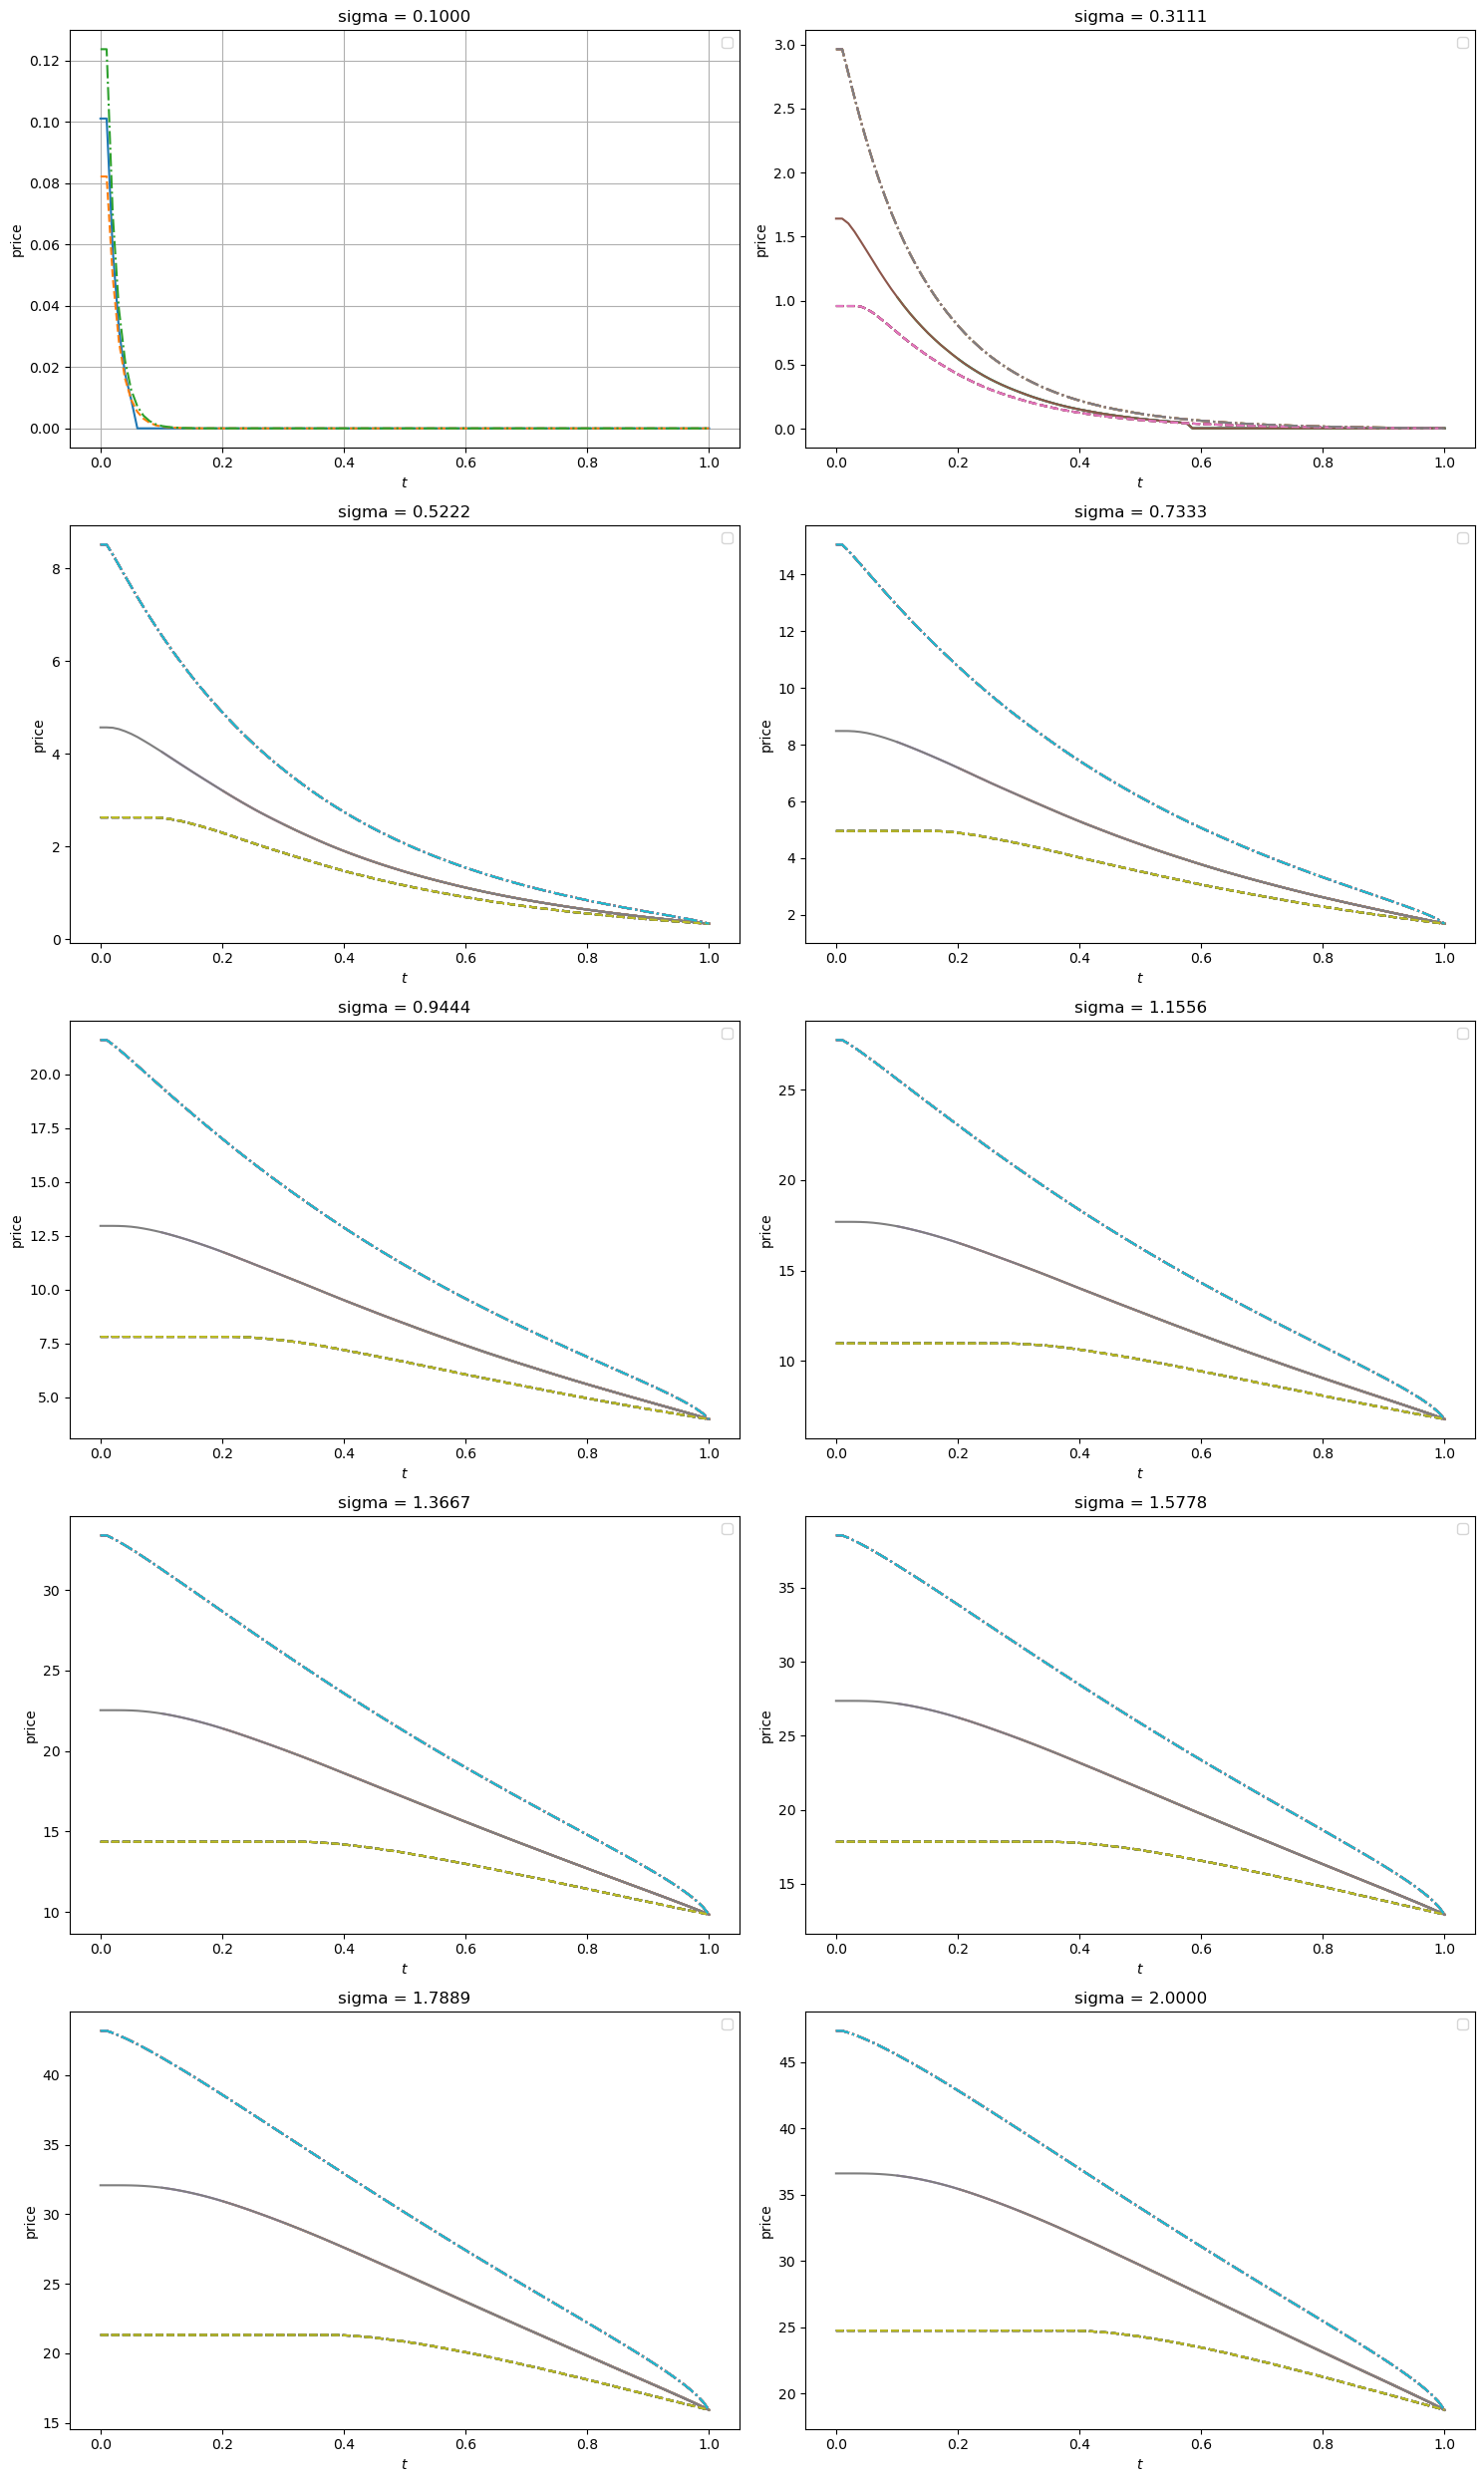

In [17]:
run_value_grid("sigma", sigma_grid, times_counter = CNT_TIMES)

если увеличить `cnt_times`, то при бОльших значениях волатильности предикты дерева и AMC будут ближе

### Время до истечения опциона `t`

In [22]:
time_grid = np.linspace(0.01, 1, num = 10)

 96%|#########5| 95/99 [00:00<00:00, 113.84it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


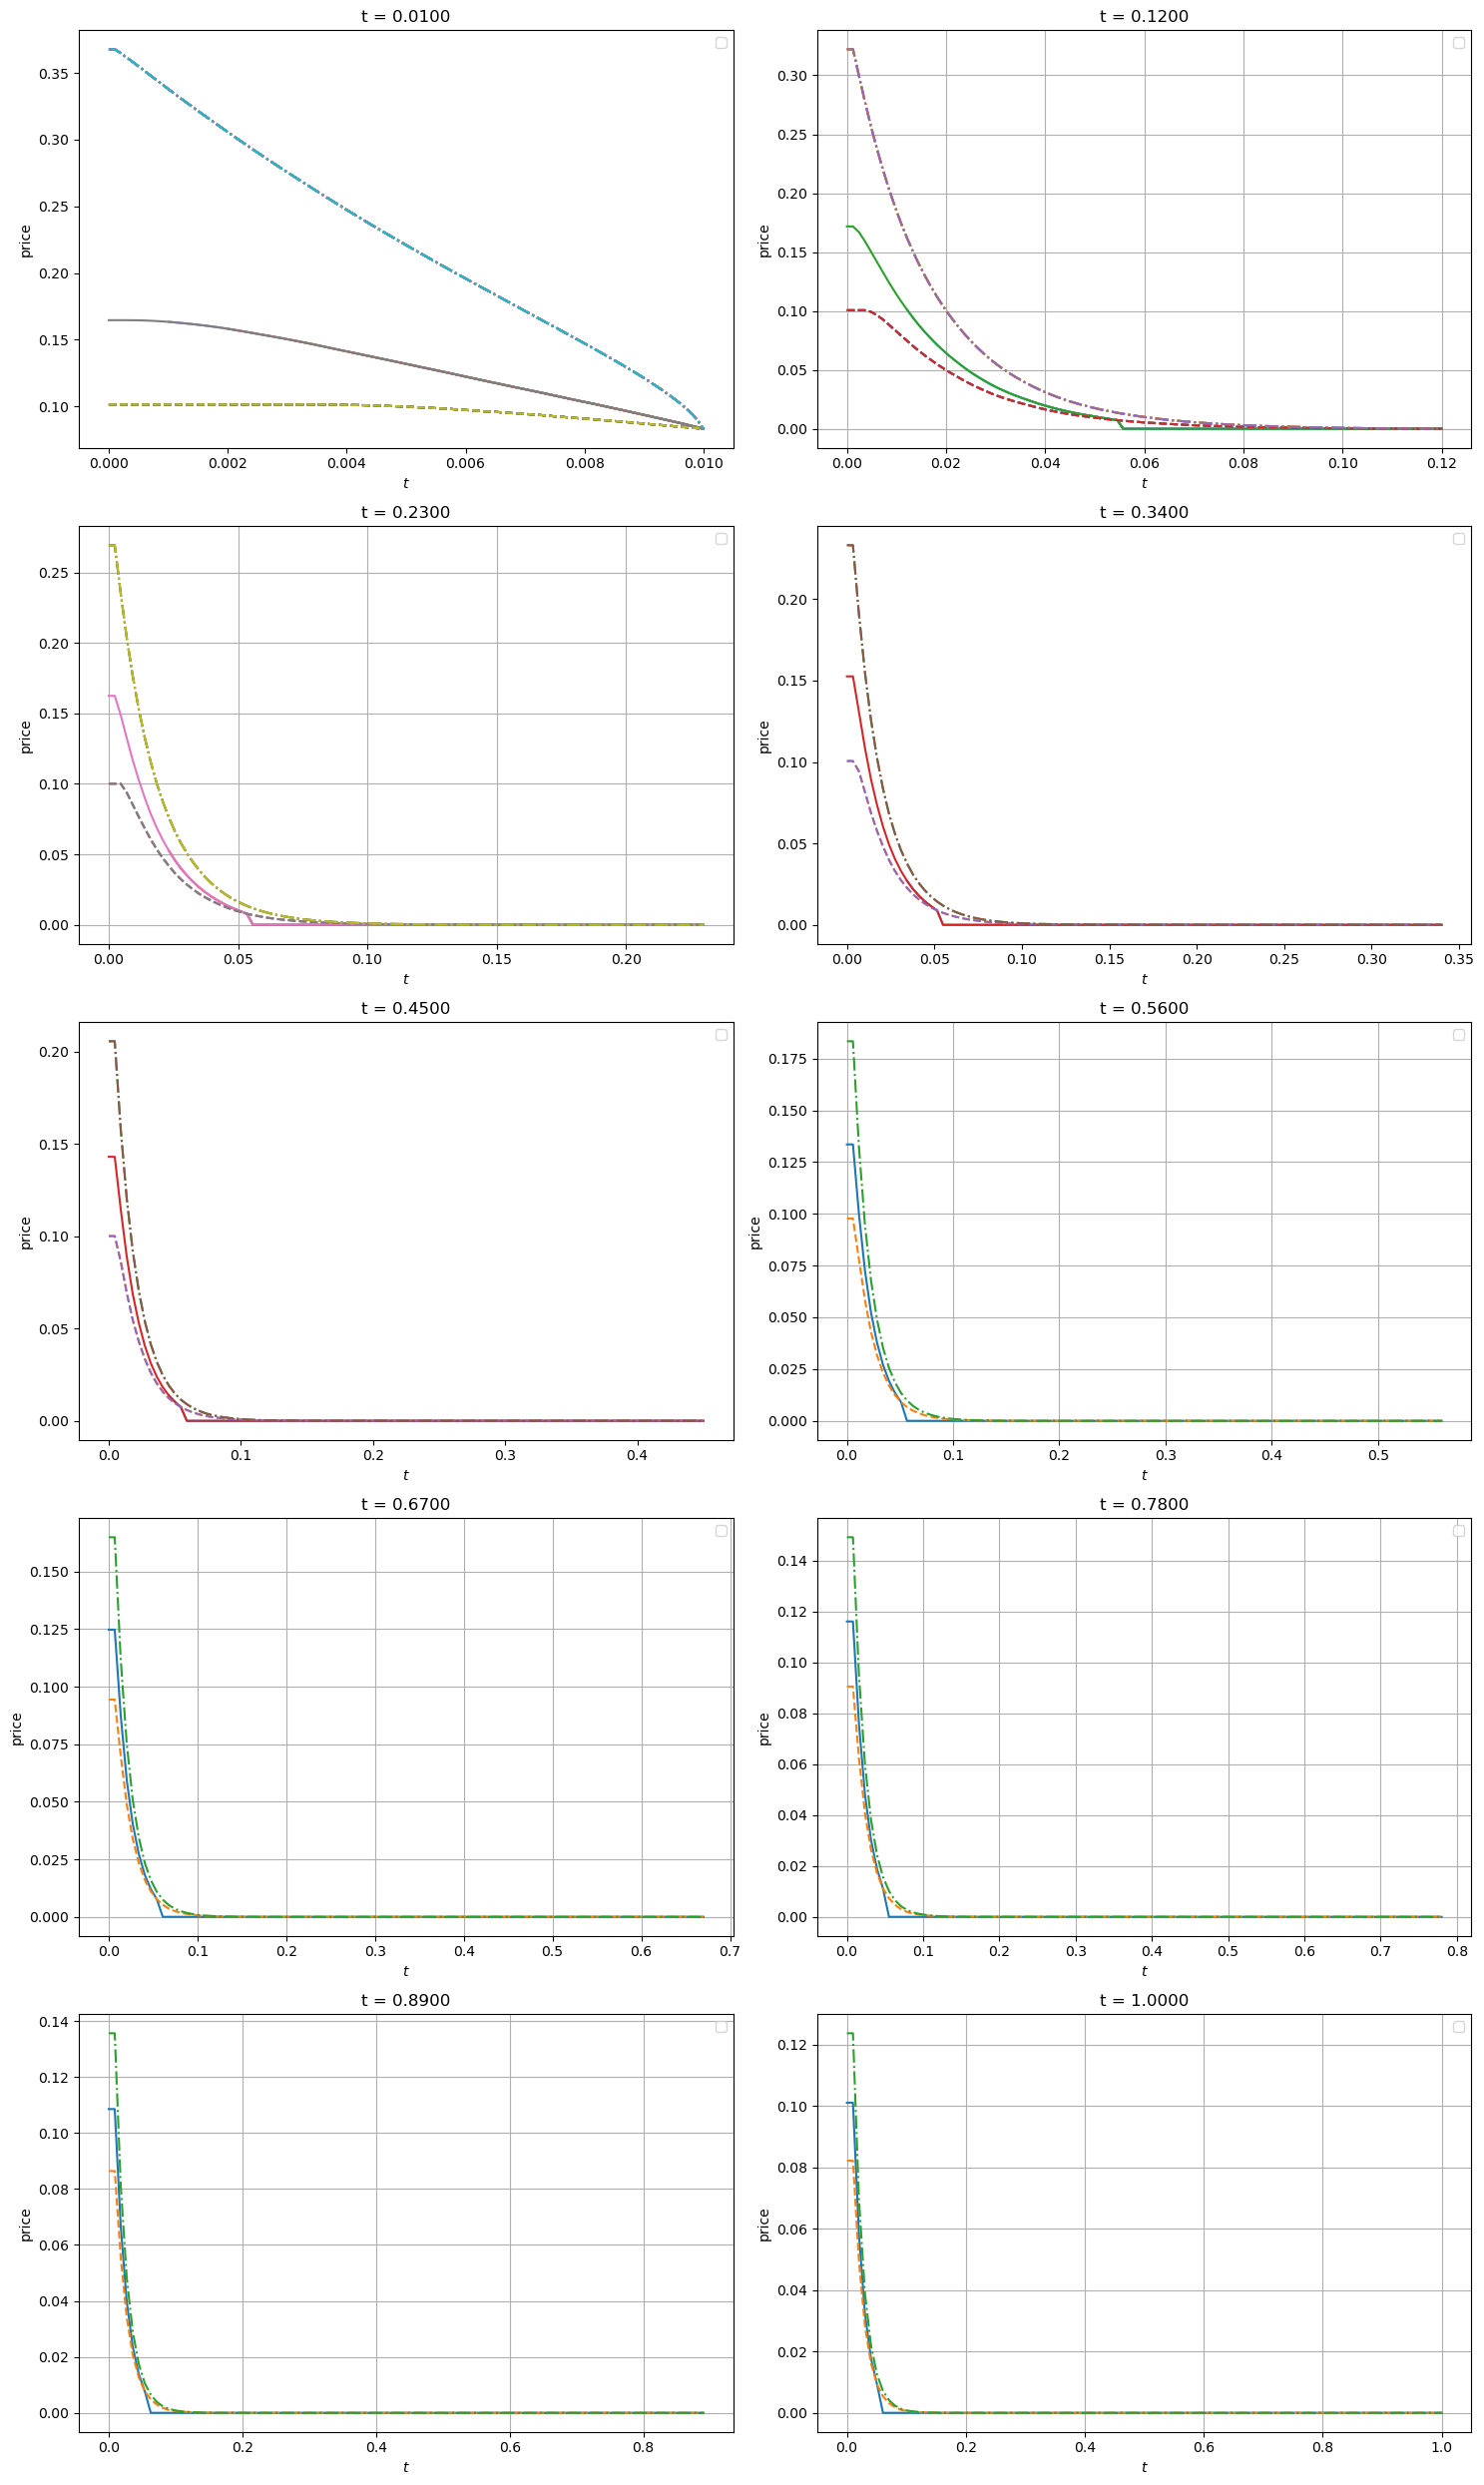

In [23]:
run_value_grid("t", time_grid, times_counter = 100)

тоже в целом всё ок, если увеличить `cnt_times` то будем ближе

# Сравнение с деревом

In [9]:
def tree_comparator(param_name, param_grid, times_counter=CNT_TIMES):
    for param_val in param_grid:
        option_params_copy = option_params.copy()
        option_params_copy[param_name] = param_val
        
        # AMC
        amc = PricerAmericanMonteCarlo(
            sampler=GeometricBrownianMotionPutSampler(
                cnt_trajectories=1_000_000,
                cnt_times=times_counter,
                seed=345,
                **option_params_copy
            ),
            regularization_alpha=1e-3
        )
        amc.price(test=False, quiet=True)
        
        # Биномиальное дерево с обновленными параметрами
        _, tree_price = price_gbm_put(**option_params_copy, cnt_times=times_counter)
        
        print(f"значение параметра {param_name} = {param_val}")
        print(f"предикт AMC {amc.price_history[0]} vs предикт дерева {tree_price[0]}")
        print()

# Варьируем `r (mu)`

In [10]:
r_linspace = np.linspace(0, 1, num = 15)

In [11]:
tree_comparator("r", r_linspace)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.0
предикт AMC 3.980723165053406 vs предикт дерева 3.9927865695358298



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.07142857142857142
предикт AMC 2.024931305537694 vs предикт дерева 2.027797129321674



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.14285714285714285
предикт AMC 1.2149928737369504 vs предикт дерева 1.2109782630937005



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.21428571428571427
предикт AMC 0.8260252170300293 vs предикт дерева 0.8162662714028909



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.2857142857142857
предикт AMC 0.6114664546746698 vs предикт дерева 0.5991276487749533



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.3571428571428571
предикт AMC 0.4791324172212705 vs предикт дерева 0.46610717438617477



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.42857142857142855
предикт AMC 0.38820165100464815 vs предикт дерева 0.36857413040622367



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.5
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.5714285714285714
предикт AMC 0.26879948044104296 vs предикт дерева 0.23488676450803508



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.6428571428571428
предикт AMC 0.22695572033086184 vs предикт дерева 0.18606939286989452



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.7142857142857142
предикт AMC 0.19246065290853248 vs предикт дерева 0.14421344302931385



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.7857142857142857
предикт AMC 0.16356530346318918 vs предикт дерева 0.10741531178534255



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.8571428571428571
предикт AMC 0.13944878487987022 vs предикт дерева 0.07147435650532494



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.9285714285714285
предикт AMC 0.11878733401140927 vs предикт дерева 0.03571907831874379



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 1.0
предикт AMC 0.10101581087409595 vs предикт дерева 0.0



видим, что при `cnt_times = 100` дереву в конце становится плохо. возьмём `cnt_times = 300` и сравним выходы AMC и дерева при последних значениях `r`. Дерево должно сблизиться с AMC

In [13]:
last_r_vals = (0.8571428571428571, 0.9285714285714285, 1.0)
LAST_CNT_TIMES = 300

In [14]:
tree_comparator("r", last_r_vals, LAST_CNT_TIMES)

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 0.8571428571428571
предикт AMC 0.1893585112359196 vs предикт дерева 0.17262052606407421



  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 0.9285714285714285
предикт AMC 0.170544216422445 vs предикт дерева 0.1522677277308465



  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 1.0
предикт AMC 0.1543026551745543 vs предикт дерева 0.13355642198113213



# Варьируем `sigma`

In [16]:
sigma_grid = np.linspace(0.1, 2, num = 10)

In [17]:
tree_comparator("sigma", sigma_grid, 100)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.1
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.3111111111111111
предикт AMC 3.3043105942545608 vs предикт дерева 3.2885654495701395



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.5222222222222223
предикт AMC 8.22398104416681 vs предикт дерева 8.232584022410279



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.7333333333333333
предикт AMC 13.939609816164824 vs предикт дерева 13.956015207468536



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.9444444444444444
предикт AMC 19.916769266507334 vs предикт дерева 19.97072966160143



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.1555555555555557
предикт AMC 25.878933267822497 vs предикт дерева 25.93508332597537



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.3666666666666667
предикт AMC 31.698218031245112 vs предикт дерева 31.72825140439927



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.577777777777778
предикт AMC 37.29460743935396 vs предикт дерева 37.29690483538323



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.788888888888889
предикт AMC 42.601922078502284 vs предикт дерева 42.608939972321984



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 2.0
предикт AMC 47.54884644059961 vs предикт дерева 47.51805277677689



# Варьируем `t`

In [18]:
time_grid = np.linspace(0.01, 1, num = 10)

In [19]:
tree_comparator("t", time_grid, 100)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.01
предикт AMC 0.24561178540850978 vs предикт дерева 0.2456766664113904



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.12
предикт AMC 0.3557258654834956 vs предикт дерева 0.35266948857362745



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.23
предикт AMC 0.355101568846795 vs предикт дерева 0.3487929954679672



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.34
предикт AMC 0.35014906636261517 vs предикт дерева 0.34282606387015546



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.45
предикт AMC 0.3455279895916441 vs предикт дерева 0.33776264452504107



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.56
предикт AMC 0.34087669944422566 vs предикт дерева 0.3296732662915146



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.67
предикт AMC 0.33594099151174106 vs предикт дерева 0.32125819008656387



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.78
предикт AMC 0.33117014246191073 vs предикт дерева 0.3121302799644024



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.89
предикт AMC 0.32615900694906297 vs предикт дерева 0.30222483354546303



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 1.0
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



# Многомерный AMC

In [3]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 2],
        strike = 50
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:08<00:00,  3.56it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


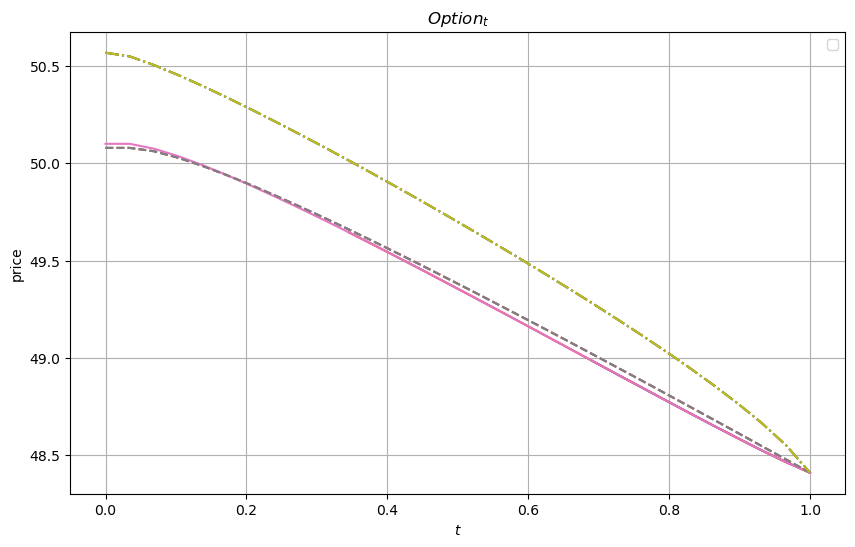

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()

######## strike = 50

In [12]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 25
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:04<00:00,  5.71it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


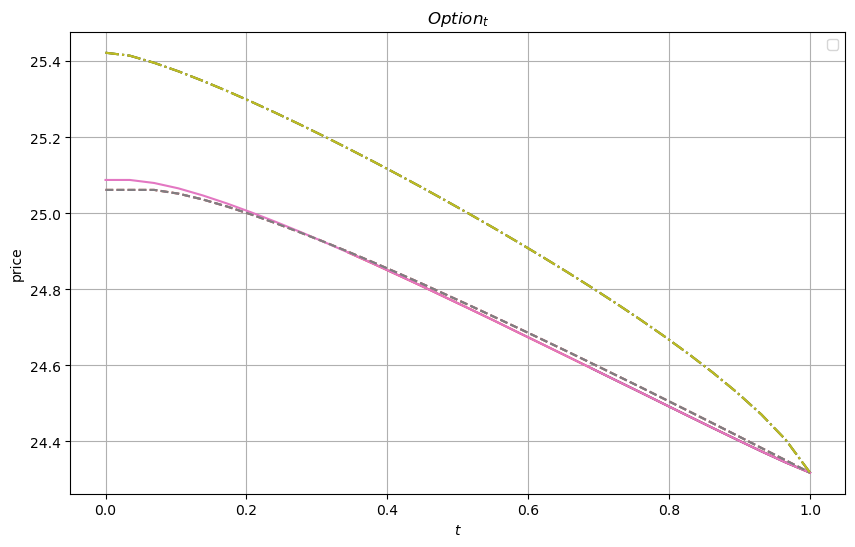

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()

##### strike = 25

In [14]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 10
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:05<00:00,  5.69it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


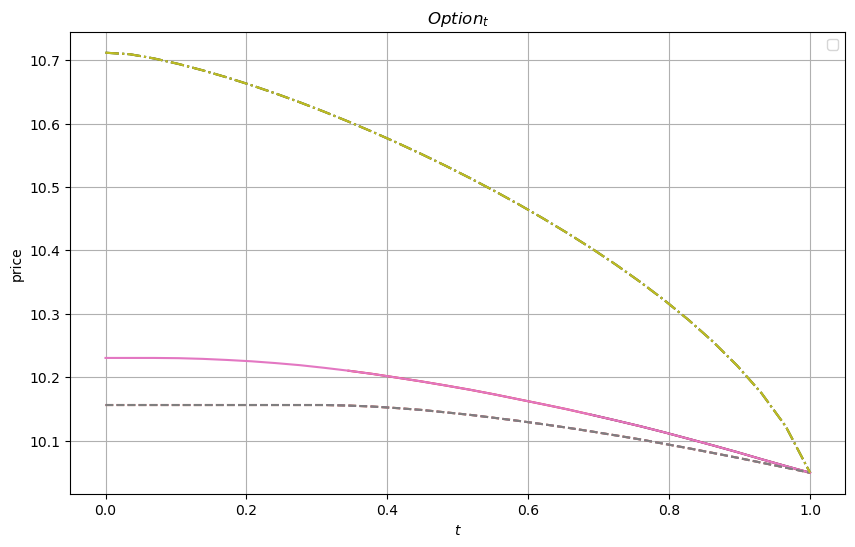

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()


####### strike = 10

In [16]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 0.
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:03<00:00,  7.12it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


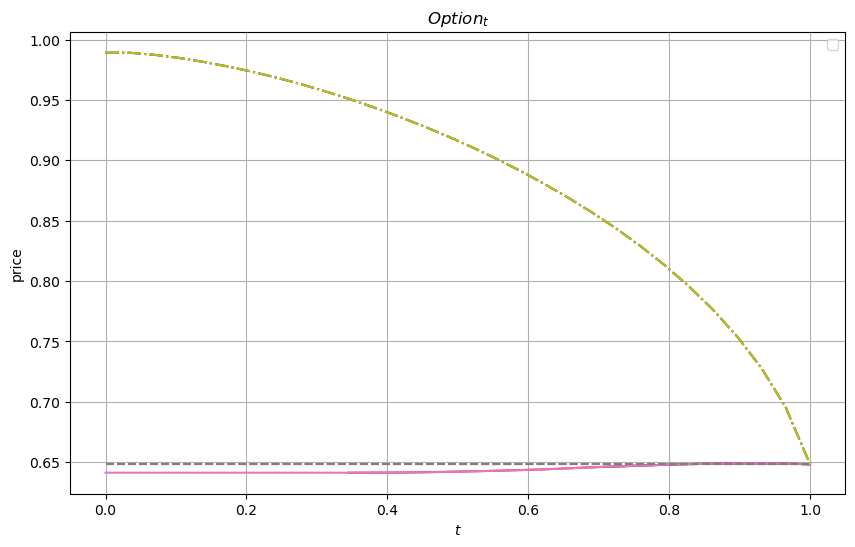

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()


####### strike = 0

## Посмотрим на поведение многомерного AMC в з-ти от размерности базиса при `strike = 0`

Фиксируем `cnt_traj = 1_000_000`

In [6]:
option_basis_test_params = {
    "sigmas": [0.2, 0.3], 
    "strike": 0.,        
    "r": 0.05,            
    "t": 1.0,              
    "cnt_trajectories": 1_000_000,  
    "cnt_times": 50,     
    "seed": 345           
}

In [4]:
def analyze_basis_impact(degrees, option_basis_test_params, regularization_alpha=1e-4):
    fig, axes = plt.subplots(len(degrees), 1, figsize=(10, 6 * len(degrees)))
    if len(degrees) == 1:
        axes = [axes]  

    for idx, degree in enumerate(degrees):
        sampler = WienerRainbowPutOptionSampler(**option_basis_test_params)
        amc = PricerAmericanMonteCarlo(
            sampler=sampler,
            degree=degree,
            regularization_alpha=regularization_alpha
        )

        ax = axes[idx]
        amc.price(test=True, quiet=False, ax=ax)
        ax.set_title(f"Degree = {degree}")
        ax.legend(["AMC Price", "Lower Bound", "Upper Bound"])

    plt.tight_layout()
    plt.show()

 98%|#########7| 48/49 [00:35<00:00,  1.32it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


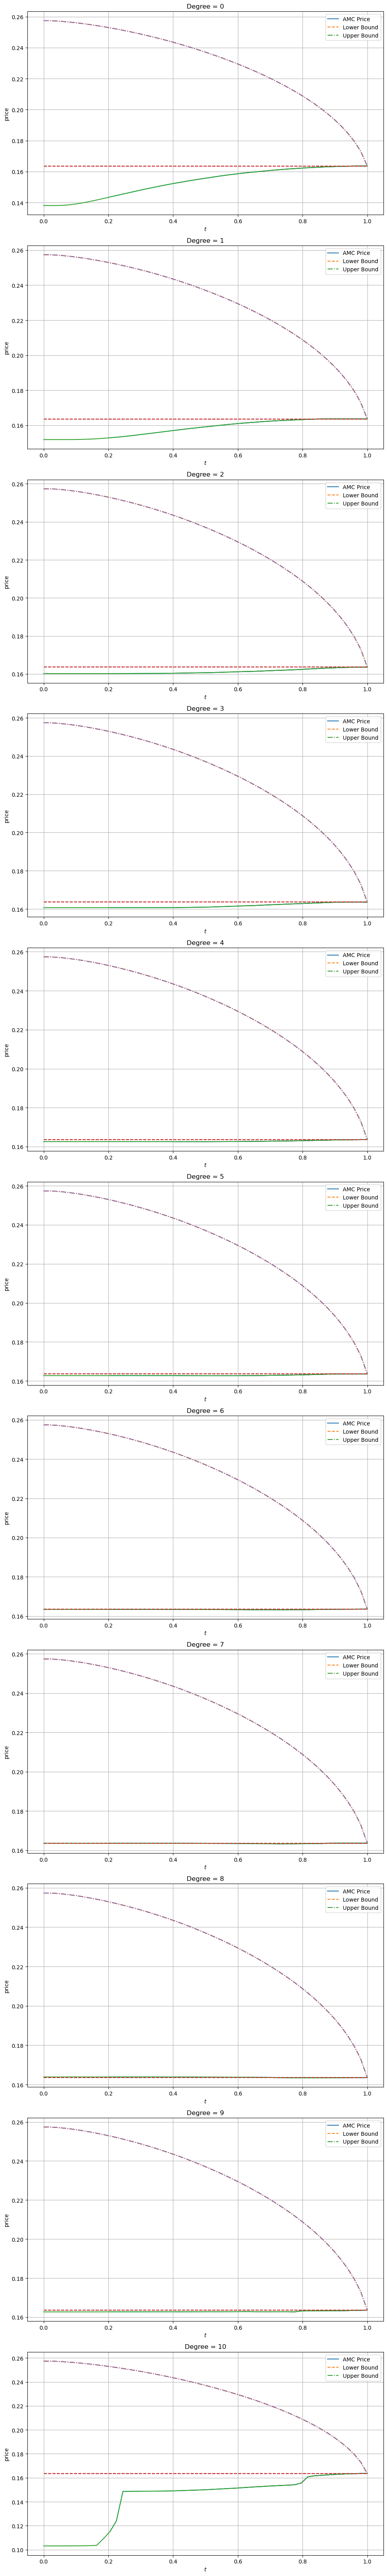

In [7]:
degrees = tuple(i for i in range(11))
analyze_basis_impact(degrees, option_basis_test_params)


##################### Не надо смотреть на легенду. Зелёное - это AMC, штриховая линия - нижняя оценка. Штрих - пунктир - верхняя оценка #############################

# Возьмем другой `strike = 10`

In [22]:
option_basis_test_params["strike"] = 10

 98%|#########7| 48/49 [00:31<00:00,  1.58it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


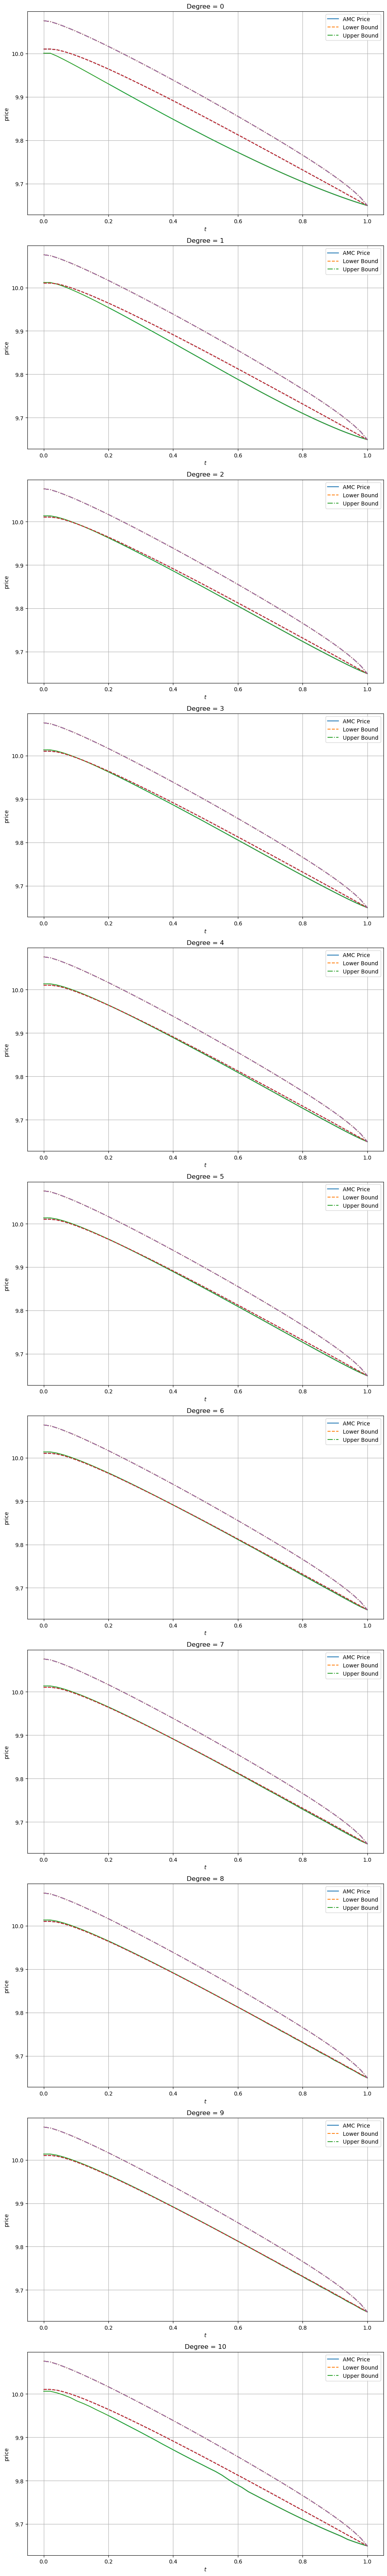

In [23]:
analyze_basis_impact(degrees, option_basis_test_params)

# `strike = 15`

In [26]:
option_basis_test_params["strike"] = 15

 98%|#########7| 48/49 [00:28<00:00,  1.67it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


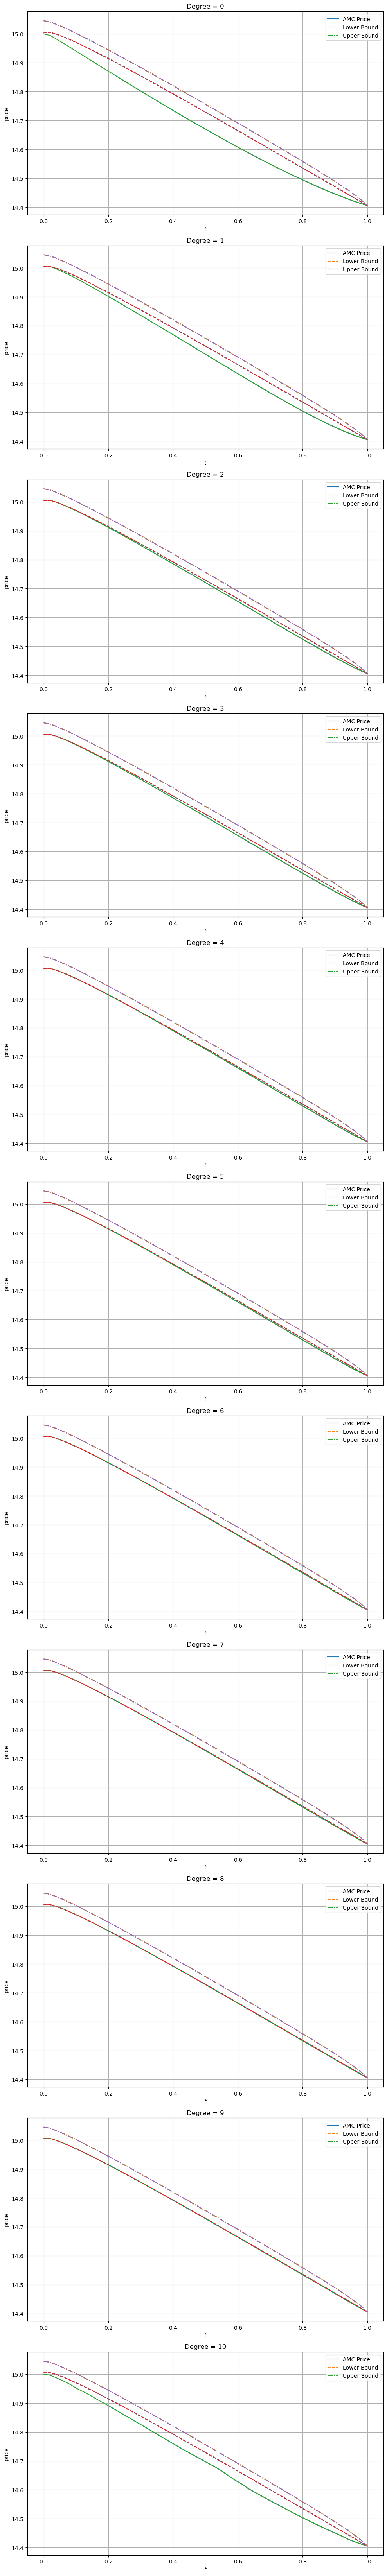

In [27]:
analyze_basis_impact(degrees, option_basis_test_params)

Дальше при увеличении `stike` оно уже всё будет в одну сплошную неразличимую линию, поэтому я брал небольшие значения. 